In [1]:
import torch
import numpy as np
import pandas as pd

torch.manual_seed(42)
np.random.seed(42)

data = pd.read_csv('fish_species.csv')
print(f'shape: {data.shape}')

y = data.pop("Species").to_numpy()
X = data.to_numpy()
print(f'shape-X: {X.shape}, shape-y: {y.shape}')

shape: (119, 3)
shape-X: (119, 2), shape-y: (119,)


In [2]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y)

plt.title('Espaço de Atributos')
plt.xlabel('Height')
plt.ylabel('Weight')

plt.show()

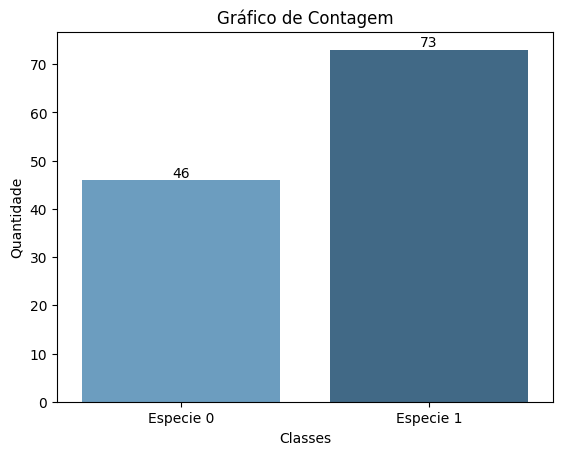

In [3]:
from sklearn.preprocessing import MaxAbsScaler
import seaborn as sns

X = MaxAbsScaler().fit_transform(X)

y_cat = ['Especie 0' if yi == 0 else 'Especie 1' for yi in y]

ax = sns.countplot(x=y_cat, palette='Blues_d')

ax.set(title='Gráfico de Contagem',
      xlabel='Classes',
      ylabel='Quantidade')

ax.bar_label(ax.containers[0])

plt.show()

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((95, 2), (95,), (24, 2), (24,))

In [5]:
import torch.nn as nn

class Perceptron(nn.Module):

    def __init__(self, in_size, out_size):
        super().__init__()

        self.linear = nn.Linear(in_size, out_size)

    def forward(self, X):
        return torch.sigmoid(self.linear(X))

In [6]:
from time import sleep
from IPython import display
model = Perceptron(in_size=X_train.shape[1], out_size=1)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32)

def plot_fit(X, y, model, loss, epoch):
    plt.close()

    weights = model.linear.weight.detach().numpy()[0]
    bias = model.linear.bias.item()

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 100),
        np.linspace(y_min, y_max, 100)
    )

    input = torch.tensor(np.c_[xx.flatten(), yy.flatten()], dtype=torch.float32)

    plt.contour(xx, yy, model(input).detach().reshape(xx.shape), levels=[.5])
    plt.scatter(X[:, 0], X[:, 1], c=y)

    # Mostra o erro, os pesos e o bias a cada época
    plt.title(f'Época [{epoch}/{epochs}] - Erro = {(loss):.4f}, w2 = {weights[1]:.4f}, w1 = {weights[0]:.4f}, b = {model.linear.bias.item():.4f}')

    plt.xlabel('Atributo 0')
    plt.ylabel('Atributo 1')

    display.display(plt.gcf())

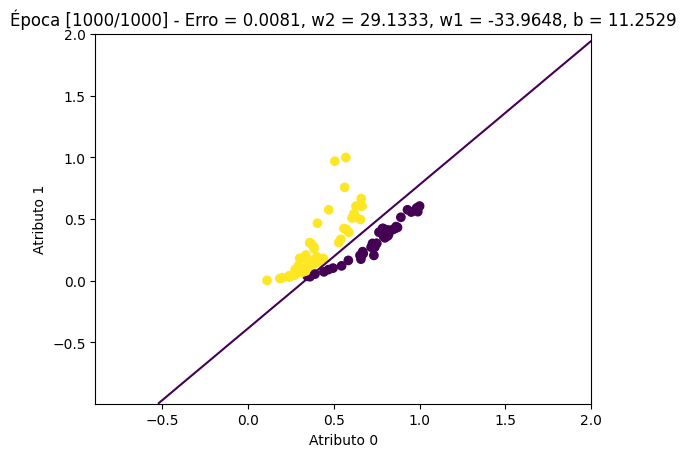

In [7]:
import torch.optim as optim

# Definimos a função de perda (binary cross-entropy loss)
criterion = nn.BCELoss()

# Definimos o otimizador
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Definimos o número de épocas de treinamento
epochs = 1000

# Criamos uma lista para salvar os erros de treinamento
train_errors = []

# Realizamos o treinamento do modelo

# Para cada época
for epoch in range(1, epochs + 1):

    # Para cada amostra e respectivo rótulo
    for xi, yi in zip(X_train_tensor, y_train_tensor):

        # Zera o gradiente
        optimizer.zero_grad()

        # Realiza a previsão
        output = model(xi)

        # Calcula o erro
        loss = criterion(output, yi)

        # Propaga o erro
        loss.backward()

        # Atualiza os parâmetros
        optimizer.step()

    # Salva o erro da época atual
    train_errors.append(loss.item())
    
# Plota o fit da superfície de separação
plot_fit(X_train_tensor, y_train_tensor, model, loss.item(), epoch)

display.clear_output(wait=True)
plt.show()

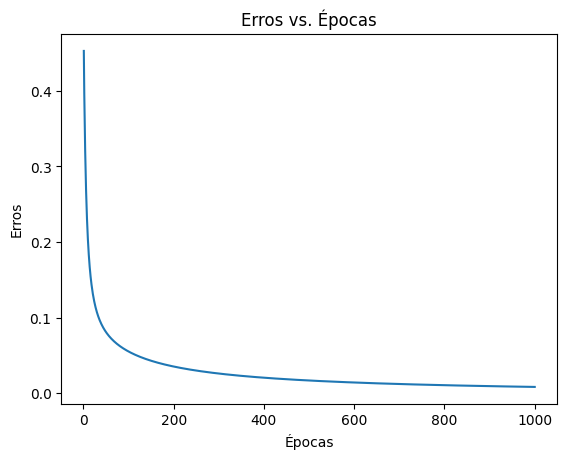

In [8]:
plt.plot(range(1, len(train_errors) + 1), train_errors)

plt.title('Erros vs. Épocas')
plt.ylabel('Erros')
plt.xlabel('Épocas')

plt.show()

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

y_pred = model.forward(X_test_tensor).detach().reshape(-1)
y_pred = np.array([1 if y >= 0.5 else 0 for y in y_pred])

acc = accuracy_score(y_test, y_pred) * 100
prec = precision_score(y_test, y_pred) * 100
rec = recall_score(y_test, y_pred) * 100

print(f'Acurácia = {acc:.2f}%')
print(f'Precisão = {prec:.2f}%')
print(f'Recall = {rec:.2f}%')

print(classification_report(y_test, y_pred, target_names=['Negativo', 'Positivo']))

Acurácia = 100.00%
Precisão = 100.00%
Recall = 100.00%
              precision    recall  f1-score   support

    Negativo       1.00      1.00      1.00        10
    Positivo       1.00      1.00      1.00        14

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



In [10]:
from sklearn.metrics import confusion_matrix
import pandas as pd

labels = ['Negativo', 'Positivo']

conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = pd.DataFrame(conf_mat, index=labels, columns=labels)

ax = sns.heatmap(conf_mat, annot=True, cmap='Blues')

ax.set(
    title='Matriz de Confusão',
    xlabel='Classe Predita',
    ylabel='Classe Real'
)

plt.show()